In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, \
    classification_report, confusion_matrix



In [109]:
df = pd.read_csv('full_data.csv')
df.head(5)

/tmp/ipykernel_77757/1619776054.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_data.csv')


,customer_id,application_id,account_id,branch_id,product_id,application_date,date_loan_granted,loan_amount,first_instalment_due_date,interest_rate,...,ftd_4,age,loan_month,is_collateral,previous_loans_count,previous_loans_max_dpd,existing_client,gb_90_ever,gb_cum_slq90,gb_60_ever
0,25121517058,764446/КР,35619143897,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ДУШАНБЕ",Карзхои гуногунмаксад,1634601600000,2021-11-02,12300.0,2021-12-02,31.0,...,0,23,202110,0,0.0,NaN,NaN,0,0,0
1,847140141,766801/КР,35733163635,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ИСТАРАВШАН",Карзхои гуногунмаксад,1635120000000,2021-11-01,20000.0,2021-12-01,30.0,...,0,52,202110,1,0.0,NaN,NaN,0,0,0
2,6286580057,766319/КР,35736913632,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ИСТАРАВШАН",Карзхои гуногунмаксад,1635120000000,2021-11-05,10000.0,2021-12-06,30.0,...,7,30,202110,0,0.0,NaN,NaN,0,0,0
3,14939826396,766446/КР,35741587858,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш. КУЛОБ",Карзхои гуногунмаксад,1635120000000,2021-11-03,3300.0,2021-12-03,31.0,...,0,55,202110,0,0.0,NaN,NaN,0,0,0
4,32830136711,767392/КР,35754732217,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ДУШАНБЕ, Н.СИ...",Карзхои гуногунмаксад,1635206400000,2021-11-03,5000.0,2021-12-03,31.0,...,0,20,202110,0,0.0,NaN,NaN,0,0,0


In [110]:
import pandas as pd
import numpy as np

# Удаление ненужных столбцов (если они есть)
df_clean = df.drop(columns=['customer_id', 'application_id', 'account_id', 'branch_id', 'product_id'], errors='ignore')

# Установка порога для допустимого количества пропусков (например, 30%)
missing_threshold = 0.3

# Указание столбцов, которые нужно исключить из обработки
excluded_columns = ['gb_cum_slq90', 'gb_90_ever', 'gb_60_ever']

# Исключение этих столбцов из удаления и обработки
df_excluded = df_clean[excluded_columns] if all(col in df_clean.columns for col in excluded_columns) else pd.DataFrame()

# Исключение столбцов с пропусками больше порога, исключая указанные
missing_percentage = df_clean.isnull().mean()
columns_to_drop = missing_percentage[(missing_percentage > missing_threshold) & (~missing_percentage.index.isin(excluded_columns))].index
df_clean = df_clean.drop(columns=columns_to_drop)
print(f"Удалены столбцы с пропусками больше {missing_threshold*100}%: {list(columns_to_drop)}")

# Обработка временных столбцов
for date_col in ['application_date', 'date_loan_granted']:
    if date_col in df_clean.columns:
        # Преобразуем в datetime, если строки, иначе интерпретируем как миллисекунды
        if df_clean[date_col].dtype == 'object':
            df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce')
        elif df_clean[date_col].dtype == np.int64:  # для числовых значений
            df_clean[date_col] = pd.to_datetime(df_clean[date_col], unit='ms', errors='coerce')

# Обработка числовых данных: заполнение пропусков средним значением, исключая указанные столбцы
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if col not in excluded_columns:
        mean_value = df_clean[col].mean()
        df_clean[col] = df_clean[col].fillna(mean_value)

# Обработка категориальных данных: заполнение пропусков значением 'unknown'
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in excluded_columns:
        df_clean[col] = df_clean[col].fillna('unknown')

# Добавление исключённых столбцов обратно в итоговый DataFrame
df_clean = pd.concat([df_clean, df_excluded], axis=1)

# Удаление дублирующихся столбцов
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]

# Проверка пропусков после обработки
missing_data = df_clean.isnull().sum()
print("Количество пропусков в данных после обработки:")
print(missing_data)

# Сохранение очищенных данных
output_file = 'cleaned_data.csv'
df_clean.to_csv(output_file, index=False)
print(f"Обработанные данные сохранены в '{output_file}'")


Удалены столбцы с пропусками больше 30.0%: ['collateral_type', 'value_of_collateral', 'property_or_collateral_type', 'mobile_phone_number', 'employment_sector', 'employment_segment', 'additional_income', 'source_of_additional_income', 'state', 'rejection_reason', 'number_of_payments_in_arrears', 'default_flag', 'bki_rating', 'previous_loans_max_dpd', 'existing_client']
Количество пропусков в данных после обработки:
application_date             0
date_loan_granted            0
loan_amount                  0
first_instalment_due_date    0
interest_rate                0
                            ..
is_collateral                0
previous_loans_count         0
gb_90_ever                   0
gb_cum_slq90                 0
gb_60_ever                   0
Length: 63, dtype: int64
Обработанные данные сохранены в 'cleaned_data.csv'


In [111]:
df_clean.describe()


,application_date,date_loan_granted,loan_amount,interest_rate,number_of_instalments,instalment_or_min_instalment_amount,date_of_birth,city_of_registration,number_of_dependants,number_of_children,...,ftd_2,ftd_3,ftd_4,age,loan_month,is_collateral,previous_loans_count,gb_90_ever,gb_cum_slq90,gb_60_ever
count,235698,235698,235698.000000,235698.000000,235698.000000,235698.000000,2.356980e+05,235698.000000,235698.000000,235698.000000,...,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000,235698.000000
mean,2022-09-12 00:17:56.251813376,2022-09-13 02:20:10.233434112,10611.288828,30.515909,16.266426,841.847345,4.216966e+11,0.825387,2.100005,1.895162,...,0.868480,0.998604,1.078698,38.832230,202229.649764,0.112334,0.352591,0.007544,0.030195,0.013488
min,2021-10-01 00:00:00,2021-11-01 00:00:00,500.000000,0.000000,0.000000,0.000000,-1.331165e+12,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,202110.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-04-19 00:00:00,2022-04-20 00:00:00,3500.000000,31.000000,12.000000,338.000000,1.455840e+11,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,29.000000,202204.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-09-19 00:00:00,2022-09-19 00:00:00,6000.000000,31.000000,12.000000,546.000000,4.868640e+11,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,37.000000,202209.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-02-13 00:00:00,2023-02-14 00:00:00,12000.000000,31.000000,18.000000,979.000000,7.329312e+11,1.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,48.000000,202302.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2023-06-30 00:00:00,2023-06-30 00:00:00,476000.000000,32.000000,120.000000,476000.000000,1.671235e+12,1.000000,34.000000,13.000000,...,388.000000,357.000000,299.000000,94.000000,202306.000000,1.000000,17.000000,1.000000,1.000000,1.000000
std,NaN,NaN,12836.948048,1.757990,7.382999,3145.917523,3.903250e+11,0.379637,1.514280,1.286410,...,6.431755,6.875399,7.253814,12.370935,58.604480,0.315778,0.722364,0.086526,0.171125,0.115351


In [112]:
# Список столбцов для удаления
columns_to_drop = [
    'customer_id',  
    'application_id', 
    'account_id', 
    'application_date',
    'date_loan_granted',
    'date_of_birth',
    'city_of_registration',  
    'maximum_days_past_due_lifetime',
    'work_phone_number',
    'cumulative_delinquency',
    'ftd_1', 
    'ftd_2', 
    'ftd_3', 
    'ftd_4',
    'gb_cum_slq90',     
    'gb_90_ever',  
    # 'gb_60_ever'  # если вы хотите оставить этот столбец, не удаляйте его
]

# Удаляем ненужные столбцы
df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')

# Вывод оставшихся столбцов
print("Оставшиеся столбцы:", df_clean.columns)


Оставшиеся столбцы: Index(['loan_amount', 'first_instalment_due_date', 'interest_rate',
       'salary_payment_in_bank_account', 'loan_type', 'number_of_instalments',
       'instalment_or_min_instalment_amount', 'gender', 'city_of_living',
       'region_of_living', 'region_of_registration', 'education',
       'marital_status', 'number_of_dependants', 'number_of_children',
       'months_at_current_address', 'employment_type', 'months_at_job',
       'net_main_income', 'source_of_main_income', 'reported_expenses',
       'months_with_bank', 'current_exposure', 'client_type',
       'property_object', 'has_eschata_online', 'has_plastic_cards',
       'has_deposit', 'run_date', 'date_account_opened', 'current_balance',
       'date_last_payment', 'date_final_payment', 'due_date', 'payment_amount',
       'account_status', 'amount_due_instalment', 'principal_amount',
       'interest_accrued', 'outstanding_balance', 'arrears_amount',
       'current_days_past_due', 'maximum_days_past_du

In [113]:
# Преобразование столбцов с датами в количество дней с определенной даты
for col in ['date_account_opened', 'date_last_payment', 'date_final_payment']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        df_clean[col] = (df_clean[col] - df_clean[col].min()).dt.days  # Количество дней с минимальной даты в данных

# После этого можно применить ту же обработку с LabelEncoder
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))


/tmp/ipykernel_77757/2356138662.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')


In [114]:
numeric_df = df_clean.select_dtypes(include=['number'])

corr_matrix = numeric_df.corr()

corr_matrix.to_csv('corr_matrix.csv', index=False)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# plt.title("Корреляционная матрица числовых признаков")

# plt.savefig('correlation_heatmap.png', bbox_inches='tight')  # Сохранение в формате PNG
# plt.close()  # Закрытие графика, чтобы не занимал память

# print("Изображение сохранено как 'correlation_heatmap.png'")


In [115]:
correlation_threshold = 0.8
low_correlation_threshold = 0.05

# 1. Выбираем только числовые столбцы
numeric_df = df_clean.select_dtypes(include=['number'])

# Проверяем, что целевая переменная существует в данных
if 'gb_60_ever' not in numeric_df.columns:
    raise ValueError("'gb_60_ever' отсутствует в данных. Проверьте исходный DataFrame.")

# 2. Вычисляем корреляционную матрицу
corr_matrix = numeric_df.corr()

# 3. Корреляция с целевой переменной
target_corr = corr_matrix['gb_60_ever'].drop('gb_60_ever', errors='ignore')

# 4. Признаки с низкой корреляцией с целевой переменной
low_corr_features = target_corr[abs(target_corr) < low_correlation_threshold].index
print("Признаки с низкой корреляцией:", low_corr_features.tolist())

# 5. Признаки с высокой корреляцией между собой
# Используем stack() для обработки матрицы корреляций
stacked_corr = corr_matrix.abs().stack()
# Убираем самокорреляции (где признак сравнивается с самим собой)
stacked_corr = stacked_corr[stacked_corr.index.get_level_values(0) != stacked_corr.index.get_level_values(1)]
# Фильтруем признаки с высокой корреляцией
high_corr_pairs = stacked_corr[stacked_corr > correlation_threshold]

# Извлекаем уникальные признаки с высокой корреляцией
high_corr_features = set(high_corr_pairs.index.get_level_values(0)).union(set(high_corr_pairs.index.get_level_values(1)))
print("Признаки с высокой корреляцией между собой:", list(high_corr_features))

# 6. Итоговые признаки для удаления
features_to_drop = set(low_corr_features).union(high_corr_features)
print("Итоговые признаки для удаления:", list(features_to_drop))

# 7. Удаляем ненужные признаки
df_reduced = df_clean.drop(columns=list(features_to_drop), errors='ignore')

# 8. Выводим размерность данных
print("Размерность данных до:", df_clean.shape)
print("Размерность данных после:", df_reduced.shape)


Признаки с низкой корреляцией: ['loan_amount', 'interest_rate', 'salary_payment_in_bank_account', 'loan_type', 'number_of_instalments', 'instalment_or_min_instalment_amount', 'gender', 'city_of_living', 'region_of_living', 'region_of_registration', 'education', 'number_of_dependants', 'number_of_children', 'months_at_current_address', 'employment_type', 'months_at_job', 'net_main_income', 'source_of_main_income', 'reported_expenses', 'months_with_bank', 'current_exposure', 'client_type', 'property_object', 'has_eschata_online', 'has_plastic_cards', 'has_deposit', 'current_balance', 'date_last_payment', 'date_final_payment', 'due_date', 'payment_amount', 'account_status', 'amount_due_instalment', 'principal_amount', 'interest_accrued', 'outstanding_balance', 'arrears_amount', 'number_of_extensions', 'number_of_loans_in_bki', 'is_collateral', 'previous_loans_count']
Признаки с высокой корреляцией между собой: ['loan_month', 'region_of_registration', 'amount_due_instalment', 'first_instal

In [116]:
data = df_clean.copy()

for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

X = data.drop(columns=['gb_60_ever'], errors='ignore')
y = data['gb_60_ever']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)



RandomForestClassifier(n_jobs=-1, random_state=42)

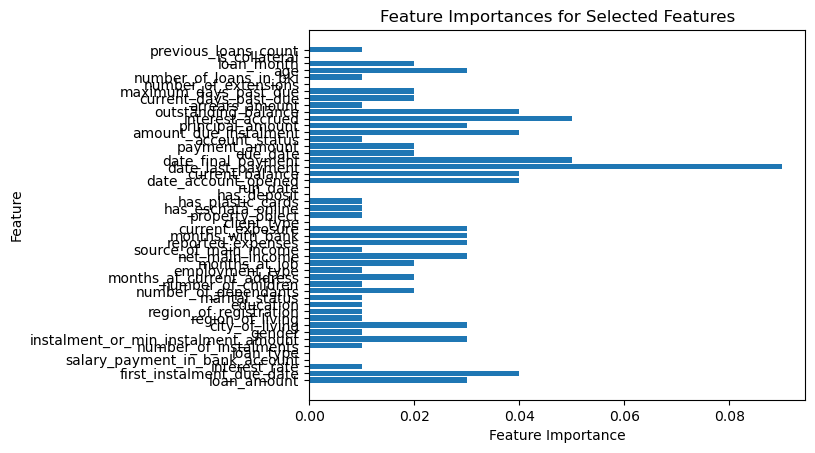

In [117]:
importances = np.round(model.feature_importances_, 2)

df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})


df.to_excel('feature_importances.xlsx', index=False)

plt.barh(X_train.columns, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Selected Features')
plt.show()

In [118]:
# Создаем копию данных
data = df_clean.copy()

# 1. Обработка текстовых данных
# Преобразование категориальных данных (например, с помощью LabelEncoder)
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# 2. Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop(columns=['gb_60_ever'], errors='ignore')  # Признаки
y = data['gb_60_ever']  # Целевая переменная

# 3. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание модели Random Forest с использованием всех ядер
model = RandomForestClassifier(random_state=42, n_jobs=-1)

# 5. RFE для отбора лучших признаков
selector = RFE(model, n_features_to_select=10)  # Оставить 10 лучших признаков
selector = selector.fit(X_train, y_train)

# 6. Получение лучших признаков
selected_features = X_train.columns[selector.support_]
X_train_selected = X_train[selected_features]

# X_train_selected = X_train_selected.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)


print("Выбранные признаки:", selected_features)


Выбранные признаки: Index(['first_instalment_due_date', 'instalment_or_min_instalment_amount',
       'net_main_income', 'reported_expenses', 'date_account_opened',
       'current_balance', 'date_last_payment', 'date_final_payment',
       'interest_accrued', 'outstanding_balance'],
      dtype='object')


In [119]:
print(X_train_selected.shape)  # Размерность признаков
print(y_train.shape)  # Размерность целевой переменной
X_train_selected

(188558, 10)
(188558,)


,first_instalment_due_date,instalment_or_min_instalment_amount,net_main_income,reported_expenses,date_account_opened,current_balance,date_last_payment,date_final_payment,interest_accrued,outstanding_balance
79687,175,979.0,2990.0,1000.0,231,0.00,438.0,572,0.00,0.00
213851,406,489.0,3500.0,1000.0,549,4148.78,582.0,893,137.78,4243.39
226181,428,625.0,1575.0,300.0,581,3750.00,578.0,740,59.90,3945.71
219413,416,195.0,1744.0,1100.0,563,1860.11,592.0,907,55.11,1879.33
77756,170,1469.0,3440.0,500.0,225,0.00,349.0,566,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
119879,245,561.0,872.0,800.0,326,4459.27,596.0,851,128.79,4489.57
103694,216,860.0,4000.0,2060.0,287,16142.29,589.0,1359,436.17,16361.65
131932,271,872.0,3000.0,1250.0,359,3297.52,599.0,700,108.41,3311.72
146867,300,1052.0,4200.0,1500.0,399,0.00,519.0,923,0.00,0.00


10


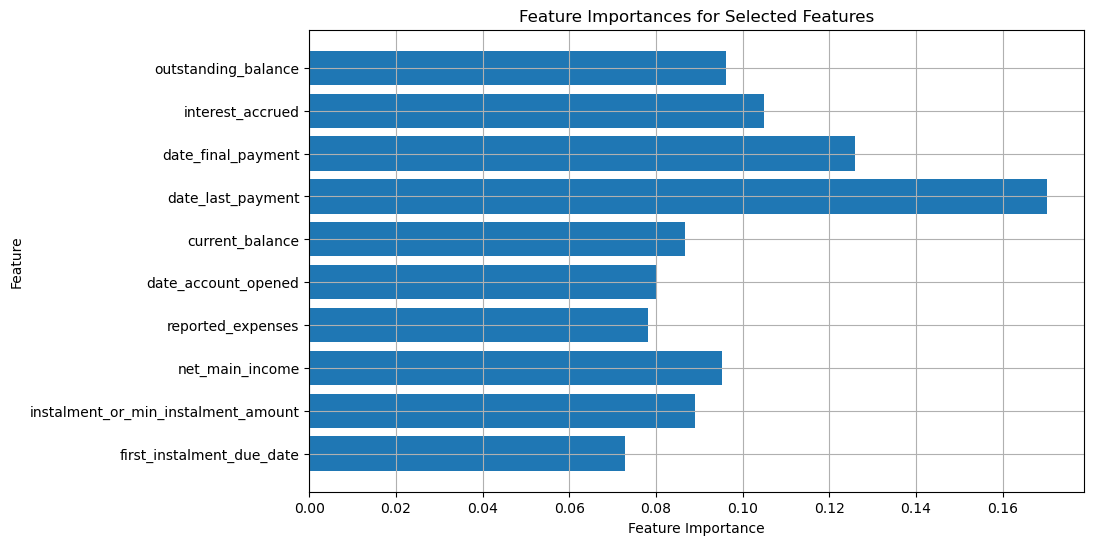

In [ ]:
X_train_selected = X_train[selected_features]

model.fit(X_train_selected, y_train)

importances = model.feature_importances_


# Строим график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X_train_selected.columns, importances)  # Используем выбранные признаки
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Selected Features')
plt.grid(True)
plt.show()

In [ ]:
# selected_features = ['first_instalment_due_date', 'instalment_or_min_instalment_amount',
#        'net_main_income', 'reported_expenses', 'date_account_opened',
#        'current_balance', 'date_last_payment', 'date_final_payment',
#        'interest_accrued', 'outstanding_balance']

# Обучение модели на выбранных признаках
model.fit(X_train_selected, y_train)

# 7. Кросс-валидация: оценка модели с использованием ROC AUC
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='roc_auc')
print(f"Средний ROC AUC при кросс-валидации: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 8. Проверка ROC AUC на тестовых данных
# Получаем предсказания вероятности для тестовых данных
y_pred_prob = model.predict_proba(X_test[selected_features])[:, 1]  # Вероятности для класса "1"
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC на тестовых данных: {roc_auc:.4f}")

Средний ROC AUC при кросс-валидации: 0.8905 ± 0.0056
ROC AUC на тестовых данных: 0.8882


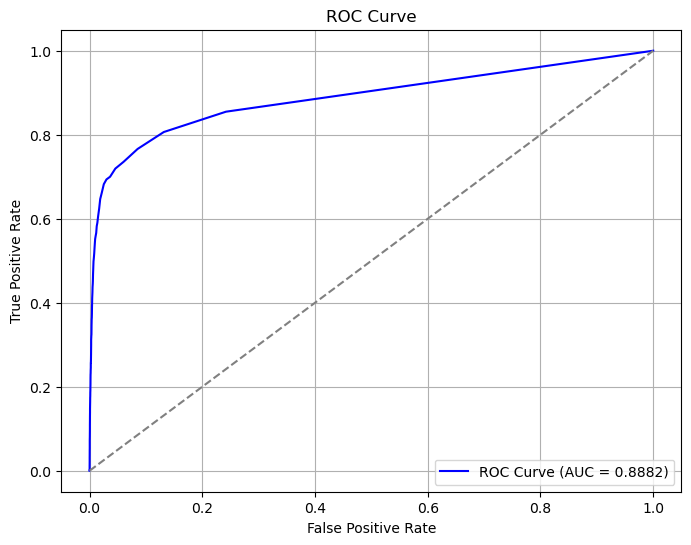

In [124]:
# 9. Визуализация ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайного предсказания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [125]:
joblib.dump(model, "model_rf1.pkl")
print("Модель сохранена в файл 'model_rf1.pkl'.")

Модель сохранена в файл 'model_rf1.pkl'.
